In [1]:
from functools import reduce

from multiprocessing import Pool

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from datetime import datetime

from db_queries import get_location_metadata

import statsmodels.api as sm

pd.options.display.max_rows = 200

import warnings
warnings.simplefilter('ignore')


In [16]:
def get_slope(df, threshold=-15):
    df['intercept'] = 1
    df['ln(case rate)'] = np.log(df['Confirmed case rate'])
    df['ln(testing rate)'] = np.log(df['Testing rate'])
    df['ln(death rate)'] = np.log(df['Death rate'])
    df.loc[(df['Confirmed case rate'] <= 0) | (df['Confirmed case rate'].isnull()), 
           'ln(case rate)'] = np.log(0.1 / df['population'].unique().item())
    df.loc[(df['Testing rate'] <= 0) | (df['Testing rate'].isnull()), 
           'ln(testing rate)'] = np.log(0.1 / df['population'].unique().item())
    df.loc[(df['Death rate'] <= 0) | (df['Death rate'].isnull()), 
           'ln(death rate)'] = np.log(0.1 / df['population'].unique().item())
    df = df.loc[df['ln(death rate)'] >= threshold]

    df['Window'] = np.floor(np.arange(len(df)) / 7)
    df['Window'] = df['Window'].astype(int)
    df['Window length'] = df.groupby('Window')['Window'].transform('count')
    df = df.loc[df['Window length'] == 7]

    coef_dfs = []
    for window in range(df['Window'].max()+1):
        case_slope = sm.OLS(df.loc[df['Window'] == window, 'ln(case rate)'],
                            np.vstack([
                                np.ones(7), np.arange(7)
                            ]).T).fit().params[1]
        testing_slope = sm.OLS(df.loc[df['Window'] == window, 'ln(testing rate)'],
                               np.vstack([
                                   np.ones(7), np.arange(7)
                               ]).T).fit().params[1]
        death_slope = sm.OLS(df.loc[df['Window'] == window, 'ln(death rate)'],
                            np.vstack([
                                np.ones(7), np.arange(7)
                            ]).T).fit().params[1]
        coef_dfs.append(pd.DataFrame({'Window': window,
                                      'Case slope': case_slope,
                                      'Testing slope':testing_slope,
                                      'Death slope': death_slope}, index=[0]))
    coef_df = pd.concat(coef_dfs)
    coef_df['location_id'] = df.index.unique().item()

    return coef_df


In [17]:
loc_df = get_location_metadata(location_set_id=111, location_set_version_id=664)
loc_df = loc_df.loc[loc_df['path_to_top_parent'].str.startswith('102,')]
loc_df = loc_df.loc[loc_df['most_detailed'] == 1]
loc_df = loc_df[['location_id', 'location_name']].reset_index(drop=True)

df = pd.read_csv('/ihme/covid-19/model-inputs/best/full_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.loc[df['location_id'].isin(loc_df['location_id'].to_list())]
df['location_id'] = df['location_id'].astype(int)
df['Confirmed case rate'] = df['Confirmed'] / df['population']
df = df[['location_id', 'Date', 'Confirmed case rate', 'Death rate', 'population']].reset_index(drop=True)
df = df.sort_values(['location_id', 'Date']).reset_index(drop=True)


test_df = pd.read_csv('/ihme/covid-19/snapshot-data/best/covid_onedrive/Testing/us_states_tests.csv')
test_df['Date'] = pd.to_datetime(test_df['date'], format='%d.%m.%Y')
test_df = test_df.loc[test_df['location_id'].isin(loc_df['location_id'].to_list())]
test_df['location_id'] = test_df['location_id'].astype(int)
test_df = test_df.rename(index=str, columns={'totaltestresults':'Tests'})

df = df.merge(test_df[['location_id', 'Date', 'Tests']])
df['Testing rate'] = df['Tests'] / df['population']
del df['Tests']
df = df.sort_values(['location_id', 'Date']).reset_index(drop=True)


In [18]:
case_df = df[['location_id', 'Date', 'Confirmed case rate', 'Testing rate', 'population']].copy()
death_df = df[['location_id', 'Date', 'Death rate']].copy()
death_df['Date'] = death_df['Date'].apply(lambda x: x - pd.Timedelta(days=8))

shift_df = case_df.merge(death_df)
shift_df = shift_df.set_index('location_id')


In [27]:
slope_df = pd.concat([get_slope(shift_df.loc[location_id]) for location_id in shift_df.index.unique()]).reset_index(drop=True)
slope_df['slope(c) - slope(d)'] = slope_df['Case slope'] - slope_df['Death slope']


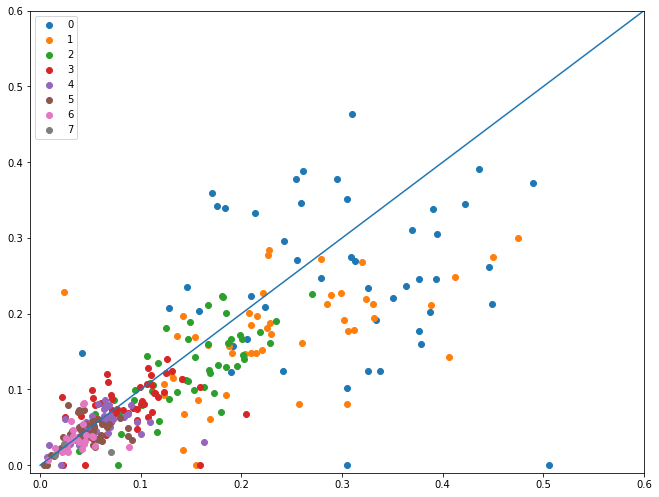

In [28]:
plt.figure(figsize=(11, 8.5))
for window in slope_df['Window'].unique():
    plt.scatter(slope_df.loc[slope_df['Window'] == window, 'Case slope'],
                slope_df.loc[slope_df['Window'] == window, 'Death slope'],
                label=window)
plt.plot((0, 0.6), (0, 0.6))
plt.legend()
plt.ylim(-0.01, 0.6)
plt.xlim(-0.01, 0.6)
plt.show()


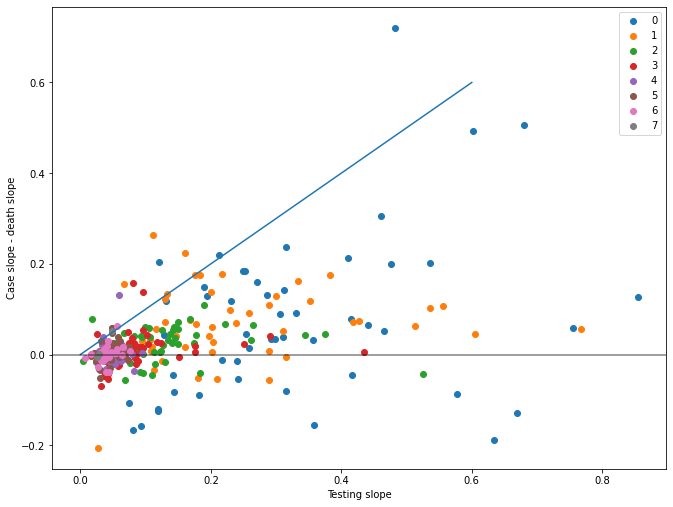

In [33]:
plt.figure(figsize=(11, 8.5))
for window in slope_df['Window'].unique():
    plt.scatter(slope_df.loc[slope_df['Window'] == window, 'Testing slope'],
                slope_df.loc[slope_df['Window'] == window, 'slope(c) - slope(d)'],
                label=window)
plt.plot((0, 0.6), (0, 0.6))
plt.axhline(0, color='black', alpha=0.5)
plt.xlabel('Testing slope')
plt.ylabel('Case slope - death slope')
plt.legend()
plt.show()
